# Autoencoder for Anomaly Detection on MNIST
---
이 노트북에서는 Autoencoder를 활용하여 MNIST 데이터셋에서 이상 탐지(Anomaly Detection)를 수행합니다.

정상 데이터로는 숫자 '0'만 학습하고, 다른 숫자(1~9)는 이상(anomaly)으로 탐지합니다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

## 1. 데이터 준비

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# 정규화
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# 정상 데이터: '0'
x_train_normal = x_train[y_train == 0]
x_test_normal = x_test[y_test == 0]
x_test_anomaly = x_test[y_test != 0]

print("Train normal shape:", x_train_normal.shape)
print("Test normal shape:", x_test_normal.shape)
print("Test anomaly shape:", x_test_anomaly.shape)

Train normal shape: (5923, 28, 28, 1)
Test normal shape: (980, 28, 28, 1)
Test anomaly shape: (9020, 28, 28, 1)


## 2. Autoencoder 모델 정의

In [3]:
input_img = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Flatten()(input_img)
x = layers.Dense(64, activation="relu")(x)
latent = layers.Dense(16, activation="relu")(x)

# Decoder
x = layers.Dense(64, activation="relu")(latent)
x = layers.Dense(28*28, activation="sigmoid")(x)
decoded = layers.Reshape((28, 28, 1))(x)

autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 784)            │        50,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,328 (403.62 KB)

 Trainable params: 103,328 (403.62 KB)

 Non-trainable params: 0 (0.00 B)

## 3. 모델 학습 (정상 데이터만 사용)

In [4]:
history = autoencoder.fit(
    x_train_normal, x_train_normal,
    epochs=20,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test_normal, x_test_normal)
)

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - loss: 0.1638 - val_loss: 0.0751
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0669 - val_loss: 0.0615
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0587 - val_loss: 0.0536
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0507 - val_loss: 0.0462
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0425 - val_loss: 0.0389
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0375 - val_loss: 0.0360
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0350 - val_loss: 0.0339
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0333 - val_loss: 0.0326
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0321 - val_loss: 0.0315
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0311 - val_loss: 0.0306
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0301 - val_loss: 0.0295
Epoch 12/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.

## 4. Reconstruction Error 계산

In [5]:
reconstructions_normal = autoencoder.predict(x_test_normal)
reconstructions_anomaly = autoencoder.predict(x_test_anomaly)

mse_normal = np.mean(np.square(x_test_normal - reconstructions_normal), axis=(1,2,3))
mse_anomaly = np.mean(np.square(x_test_anomaly - reconstructions_anomaly), axis=(1,2,3))

print("Normal MSE mean:", np.mean(mse_normal))
print("Anomaly MSE mean:", np.mean(mse_anomaly))

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Normal MSE mean: 0.021655204
Anomaly MSE mean: 0.071632914


### 정상 vs 이상 데이터의 Reconstruction Error 분포

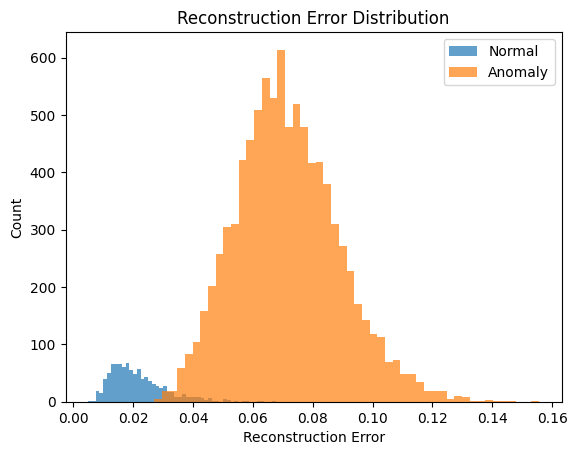

In [6]:
plt.hist(mse_normal, bins=50, alpha=0.7, label="Normal")
plt.hist(mse_anomaly, bins=50, alpha=0.7, label="Anomaly")
plt.legend()
plt.xlabel("Reconstruction Error")
plt.ylabel("Count")
plt.title("Reconstruction Error Distribution")
plt.show()

## 5. 임계값 설정 및 성능 평가

In [7]:
threshold = np.percentile(mse_normal, 95)  # 정상 데이터 기준 95%

y_true = np.concatenate([np.zeros(len(mse_normal)), np.ones(len(mse_anomaly))])
y_pred = np.concatenate([mse_normal, mse_anomaly]) > threshold

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Normal", "Anomaly"]))

auc = roc_auc_score(y_true, np.concatenate([mse_normal, mse_anomaly]))
print("ROC-AUC:", auc)

Confusion Matrix:
[[ 931   49]
 [ 217 8803]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.81      0.95      0.88       980
     Anomaly       0.99      0.98      0.99      9020

    accuracy                           0.97     10000
   macro avg       0.90      0.96      0.93     10000
weighted avg       0.98      0.97      0.97     10000

ROC-AUC: 0.9943575501153898


## 6. 시각적 예시

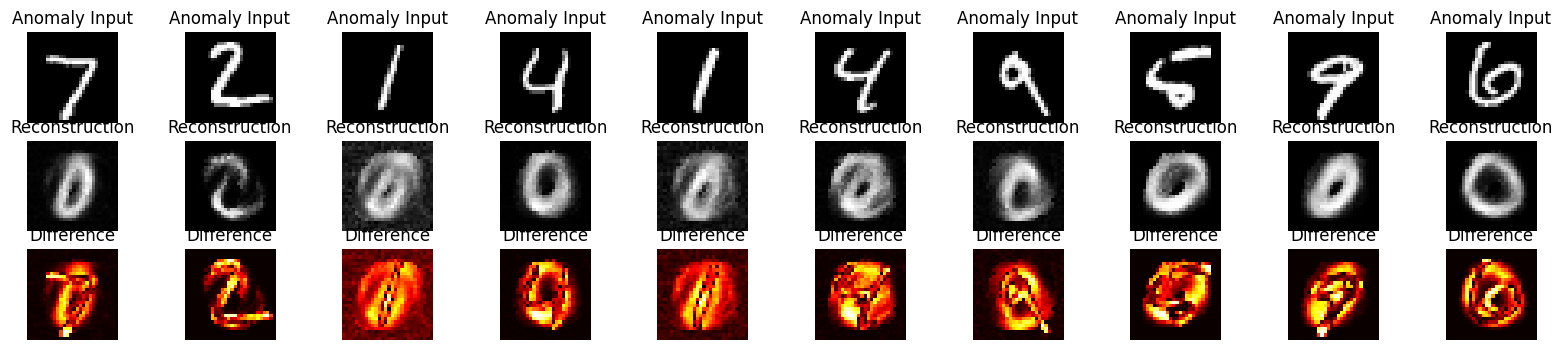

In [10]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # 원본
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_anomaly[i].reshape(28,28), cmap="gray")
    plt.title("Anomaly Input")
    plt.axis("off")

    # 복원
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(reconstructions_anomaly[i].reshape(28,28), cmap="gray")
    plt.title("Reconstruction")
    plt.axis("off")

    # 차이
    diff = np.abs(x_test_anomaly[i] - reconstructions_anomaly[i])
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(diff.reshape(28,28), cmap="hot")
    plt.title("Difference")
    plt.axis("off")
plt.show()

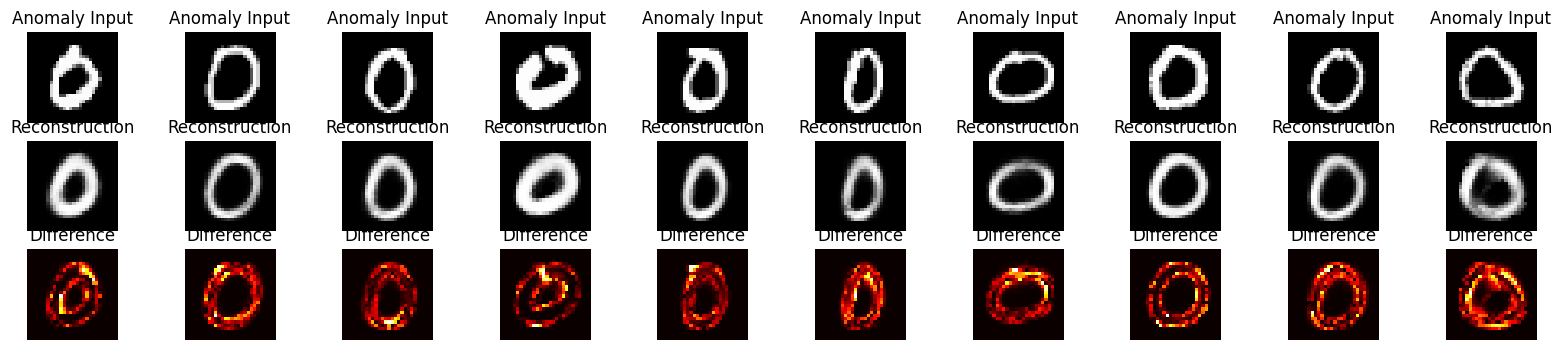

In [9]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # 원본
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_normal[i].reshape(28,28), cmap="gray")
    plt.title("Anomaly Input")
    plt.axis("off")

    # 복원
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(reconstructions_normal[i].reshape(28,28), cmap="gray")
    plt.title("Reconstruction")
    plt.axis("off")

    # 차이
    diff = np.abs(x_test_normal[i] - reconstructions_normal[i])
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(diff.reshape(28,28), cmap="hot")
    plt.title("Difference")
    plt.axis("off")
plt.show()